# Graph-based genetic algorithm for molecular design

## How is the GA implemented?

* The genetic algorithm takes an embedding of a molecule, e.g. SMILES, SMARTS, SELFIES, etc. 
* this embedding is converted to a molecule object in RDKit
* from the mol object, we have access to all atoms, bonds, valences, etc. 
* the mol object enables us to obtain the adjacency matrix using RDKit
* we can convert the adjacency matrix of the molecules to a graph repesentation ($G(V,E)$) using the networkx package and apply the implemented algorithms from graph theory

This guide walks you through the implementation step by step including code examples.

First, import some neccessary packages:

In [21]:
import numpy as np
import pandas as pd
import fragments as f
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem.Draw import MolDrawing, DrawingOptions

## General procedure

During the GA (see Fig), we first set hyperparameters (mutation rate, population size, etc.) and initilize a first population of molecules. We start with a population of 1000 hexane molecules which are known to have a very low lignin solubility. Subsequently, we select the fittest molecules using roulette wheel selection and perform *cross-over*. With a certain probability as given by the mutation rate, the molecular operations *addition*, *relocation*, *insertion*, *deletion* or *bond mutation* may occur. <br />

<div>
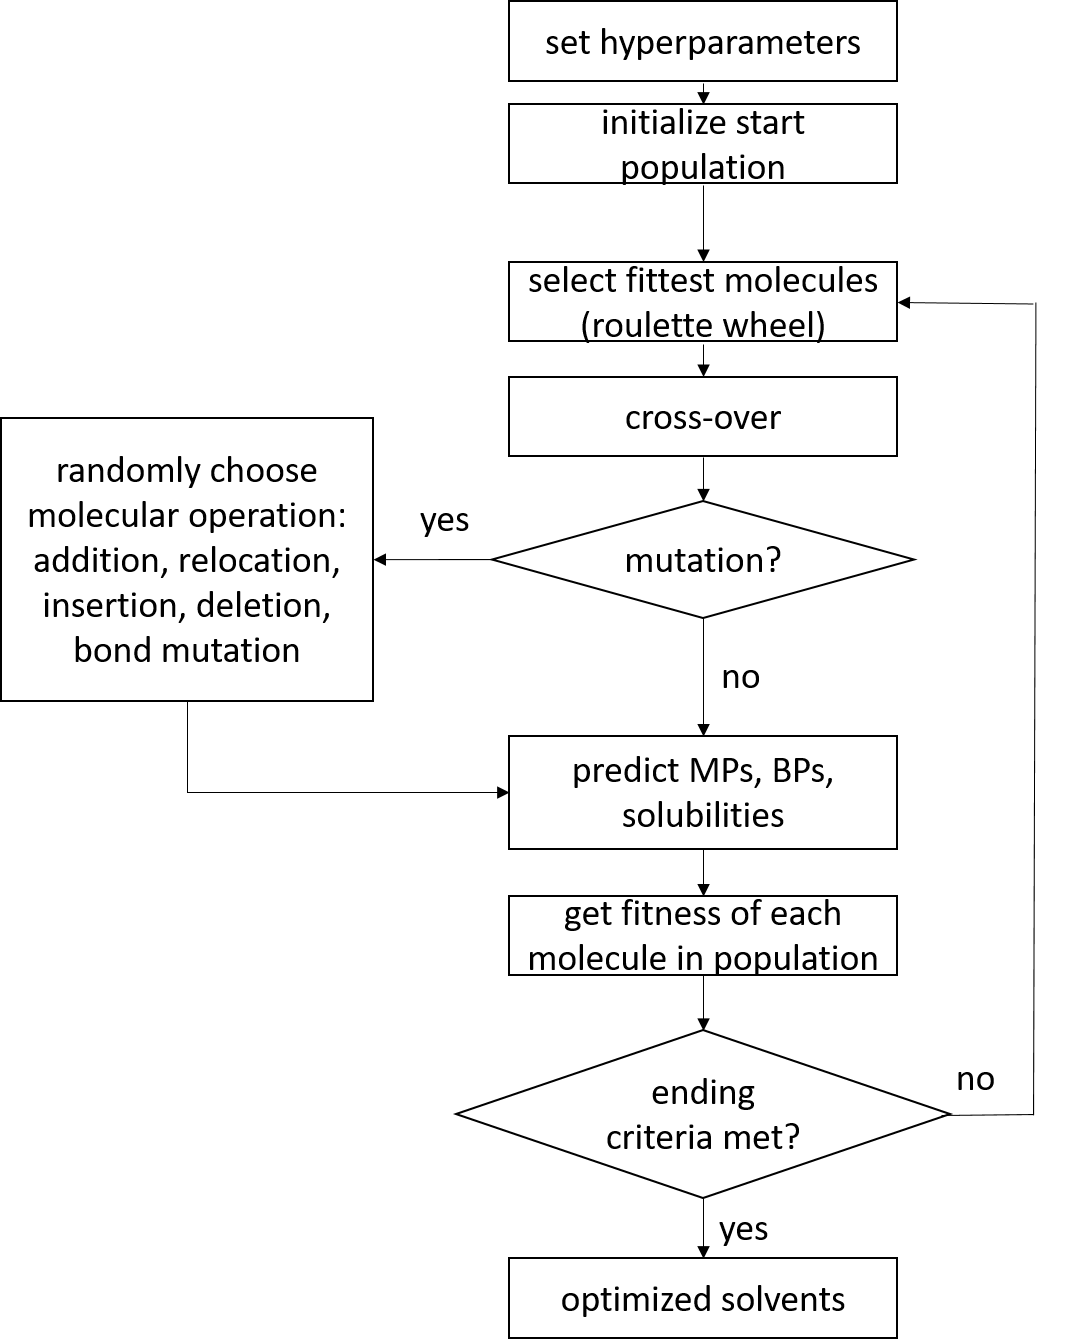
</div>


## Molecular operations


We developed two core functions, from which we can build the operations *addition*, *relocation*, *insertion* and *cross-over*.


### Fragmentation algorithm

The molecule is given in a graph representation $G(V,E)$ with vertices $V$ (also called "nodes") and edges $E$. In the representation, the vertices correspond to the atoms of a molecule and the edges to the bonds. Using the graph representation, we can now apply the algorithm [https://doi.org/10.1016/j.ipl.2013.01.016] as implemented in the networkx-package, in order to find so-called "bridges" of a graph. In graph theory, bridges are edges that - if deleted - split the graph in two or more fragments. We will illustrate this with some code examples on different molecules. Since H-atoms are treated implicitly, the molecule must at least consist of two heavy atoms.

The graph of the molecule hexane contains only bridges:

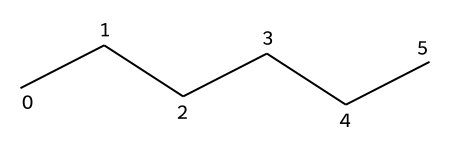

In [15]:
smi1 = 'CCCCCC'         # hexane
hexane = Chem.MolFromSmiles(smi1)

for atom in hexane.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
DrawingOptions.includeAtomNumbers = True
hexane

Using the fragmentation algorithm, from all bridges, one is randomly chosen and deleted:

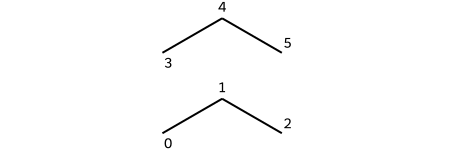

In [24]:
frag_mol_hex, flag_successful = f.fragmentor(hexane)
frag_mol_hex

Some molecules, such as phenol, only contain one bridge:

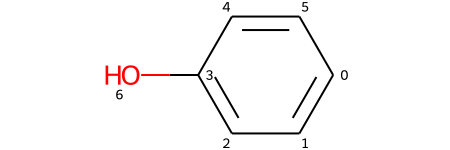

In [28]:
smi2 = 'C1=CC=C(C=C1)O' # phenol
phenol  = Chem.MolFromSmiles(smi2)

for atom in phenol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
DrawingOptions.includeAtomNumbers = True
phenol

If there is only one bridge, the this only bridge is chosen:

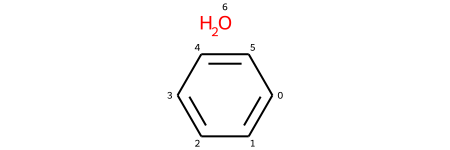

In [29]:
frag_mol_phenol, flag_successful = f.fragmentor(phenol)
frag_mol_phenol

Other molecules do not contain any bridges at all, such as benzene:

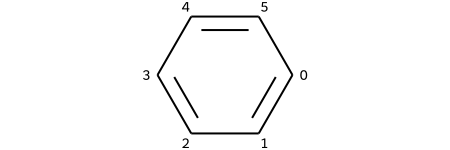

In [30]:
smi3 = 'C1=CC=CC=C1'    # benzol
benzol = Chem.MolFromSmiles(smi3)

for atom in benzol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
DrawingOptions.includeAtomNumbers = True
benzol

If the molecular graph does not contain any bridges, then there is no fragmentation:

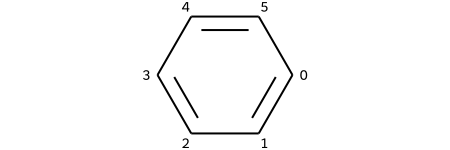

In [32]:
frag_mol_phenol, flag_successful = f.fragmentor(benzol)
frag_mol_phenol

### Combination algorithm

The comination algorithm is also fundamental for the GA. It combines two or more molecular fragments until there is only one fragment. First, we fetch the implicit valences of all atoms in each fragment. Then we randomly choose one atom from each fragment with implicit valence $\geq$ 1. For combination, a new bond is formed which can either be a single or double bond, depending on the valence. If the implicit valence is $\geq$ 2, then it is randomly chosen whether a single or double bond is formed. If there is one fragment where all atoms have implicit valence $<$ 1, the fragments cannot be combined and the algorithm fails.

Based on the fragmentation and the combination algorithm, we can now perform *addition*, *insertion*, *relocation* and *cross-over*, which are explained in the following:

#### Addition

In the genetic algorithm, we randomly choose functional groups from a pool of fragments. These fragments are then added to a given molecule using the combination algorithm. Here, we illustrate this example for hexane and phenol:

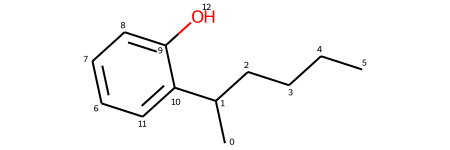

In [36]:
add_mol, flag_successful = f.addition(hexane, phenol)
for atom in add_mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
add_mol

#### Relocation

For relocation we use (i) the fragmentation algorithm to split a molecule into two or more fragments and (ii) the combination algorithm to randomly combine those fragments. Here, we use the hexane molecule as example:


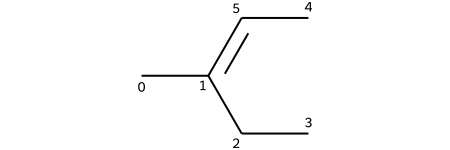

In [37]:
rel_mol, flag_successful = f.relocation(hexane)
for atom in rel_mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
rel_mol

#### Insertion

For insertion, we pick a random fragments from the pool and we have a given molecule from the population. Insertion is based on using the fragmentor on either the molecule or the fragment and then use the combinator() to obtain the combined molecule. Before we start insertion, we must check if the both, the frag and the mol can be fragmented whether the unfragmented versions can be inserted (must have at least on atom with valence >= 1). To see whether they can be fragmented, we fragment both (the frag and the mol) and see whether fragmentation was successful (use of flags). We use boolean experssions for this. Based on the bools, we see whether the mol should be fragmented and the frag should be inserted or vise versa. If both is possible, we choose randomly. We illustrate this on hexane and phenol:

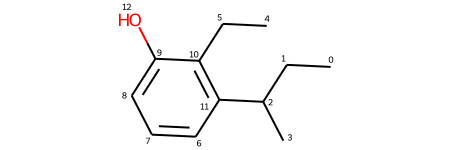

In [38]:
ins_mol, flag_successful = f.insertion(hexane, phenol)
for atom in ins_mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
ins_mol

#### Cross-over

From the population, $n_{\mathrm{fittest}}$ fittest molecules are selected using roulette wheel selection. On the selected molecules we (i) use the fragmention algorithm and obtain the parent fragments. For each of the $n_{\mathrm{children}}$ that we want to create, we choose two of the parent fragments and (ii) use the combination algorithm. $n_{\mathrm{fittest}}$ and $n_{\mathrm{children}}$ are set in the hyperparameters of the GA. 

### Deletion

During deletion, single atoms are deleted. However, not every atom can be safely deleted as some atoms may separate the molecular graph into two or more fragments. To prevent the graph from splitting, we make use of vertex connectivity from graph theory. We use find_all_note_cuts from the networkx package based on the [https://doi.org/10.1002/net.3230230604] algorithm to identify atoms that - if deleted - split the graph into two or more fragments. All other atoms can be deleted and are randomly chosen.

We illustrate this on the example of an anhydride:

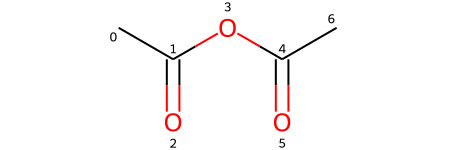

In [39]:
smi4 = 'CC(=O)OC(=O)C'  # anhydride
anhydride = Chem.MolFromSmiles(smi4)

for atom in anhydride.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
anhydride

We see that only the atoms with idices 0, 2, 5 and 6 can be deleted without splitting the molecular graph. Now we apply the deletion algorithm:

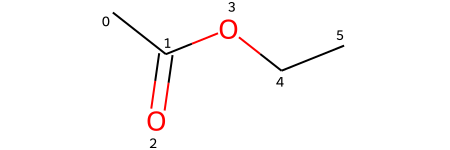

In [41]:
del_mol, flag_successful = f.deletion(anhydride)
for atom in del_mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
del_mol

### Bond mutation

To perform a bond mutation, we randomly choose a bond from the molecule and get its bond type. If the chosen bond is a single bond, we have to make sure that the implicit valence is $\geq 2$ to convert it into a double bond. If it's a double bond, we make a single bond out of it. If it's a double bond in an aromatic ring, the bond is changed to a single bond. A single bond in an aromatic ring is not changed. If the bond type cannot be changed, we try another bond in the molecule. In the following, we use phenol to illustrate the bond mutation:

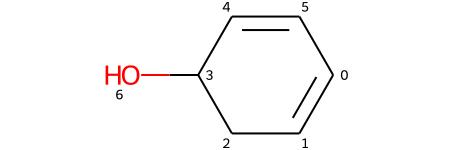

In [71]:
smi2 = 'C1=CC=C(C=C1)O' # phenol
phenol  = Chem.MolFromSmiles(smi2)

mut_mol, flag_successful = f.bond_mutation(phenol)
for atom in mut_mol.GetAtoms():
    atom.SetProp("atomNote", str(atom.GetIdx()))
mut_mol